In [28]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
print(tf.__version__)

2.14.0


In [29]:
def get_files(base_dir, target_dir):
    count = 0
    path = get_path(base_dir, target_dir)
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            count+=len(glob.glob(os.path.join(dirname, filename)))
        return path, count

def get_path(base_dir, target_dir):
    path = os.path.join(base_dir,target_dir)
    return path

In [30]:
base_dir = 'DD:/User Data/Desktop/Major Project/Dataset/Pneumonia Disease Detection-Dataset'

train_normal_dir = 'D:/User Data/Desktop/Major Project/Dataset/Pneumonia Disease Detection-Dataset/train/normal'
train_pneumonia_dir = 'D:/User Data/Desktop/Major Project/Dataset/Pneumonia Disease Detection-Dataset/train/opacity'

val_normal_dir = 'D:/User Data/Desktop/Major Project/Dataset/Pneumonia Disease Detection-Dataset/val/normal'
val_pneumonia_dir = 'D:/User Data/Desktop/Major Project/Dataset/Pneumonia Disease Detection-Dataset/val/opacity'

test_normal_dir = 'D:/User Data/Desktop/Major Project/Dataset/Pneumonia Disease Detection-Dataset/test/normal'
test_pneumonia_dir = 'D:/User Data/Desktop/Major Project/Dataset/Pneumonia Disease Detection-Dataset/test/opacity'


train_normal_path, train_normal_count = get_files(base_dir,train_normal_dir)
train_pneumonia_path, train_pneumonia_count = get_files(base_dir,train_pneumonia_dir)

val_normal_path, val_normal_count = get_files(base_dir,val_normal_dir)
val_pneumonia_path, val_pneumonia_count = get_files(base_dir,val_pneumonia_dir)

test_normal_path, test_normal_count = get_files(base_dir,test_normal_dir)
test_pneumonia_path, test_pneumonia_count = get_files(base_dir,test_pneumonia_dir)

print("No of Train Images: {}".format(train_normal_count + train_pneumonia_count))
print(" \u2022 No of Normal Images {}".format(train_normal_count))
print(" \u2022 No of Pneumonia Images {}".format(train_pneumonia_count))

print("No of Validation Images: {}".format(val_normal_count + val_pneumonia_count))
print(" \u2022 No of Normal Images {}".format(val_normal_count))
print(" \u2022 No of Pneumonia Images {}".format(val_pneumonia_count))

print("No of Test Images: {}".format(test_normal_count + test_pneumonia_count))
print(" \u2022 No of Normal Images {}".format(test_normal_count))
print(" \u2022 No of Pneumonia Images {}".format(test_pneumonia_count))

No of Train Images: 4192
 • No of Normal Images 1082
 • No of Pneumonia Images 3110
No of Validation Images: 1040
 • No of Normal Images 267
 • No of Pneumonia Images 773
No of Test Images: 624
 • No of Normal Images 234
 • No of Pneumonia Images 390


In [31]:
train_data = []
for filename in os.listdir(train_normal_path):
    train_data.append((os.path.join(train_normal_path,filename),0))

for filename in os.listdir(train_pneumonia_path):
    train_data.append((os.path.join(train_pneumonia_path,filename),1))

train_data = pd.DataFrame(train_data, columns=['image_path', 'label'], index=None)
train_data = train_data.sample(frac=1).reset_index(drop=True)
        
val_data = []
for filename in os.listdir(val_normal_path):
    val_data.append((os.path.join(val_normal_path,filename),0))

for filename in os.listdir(val_pneumonia_path):
    val_data.append((os.path.join(val_pneumonia_path,filename),1))
        
val_data = pd.DataFrame(val_data, columns=['image_path', 'label'], index=None)
        
test_data = []
for filename in os.listdir(test_normal_path):
    test_data.append((os.path.join(test_normal_path,filename),0))

for filename in os.listdir(test_pneumonia_path):
    test_data.append((os.path.join(test_pneumonia_path,filename),1))

test_data = pd.DataFrame(test_data, columns=['image_path', 'label'], index=None)

print("Train Data {}".format(train_data.shape))
print("Validation Data {}".format(val_data.shape))
print("Test Data {}".format(test_data.shape))

Train Data (4192, 2)
Validation Data (1040, 2)
Test Data (624, 2)


In [32]:
train_data


,image_path,label
0,D:/User Data/Desktop/Major Project/Dataset/Pne...,0
1,D:/User Data/Desktop/Major Project/Dataset/Pne...,0
2,D:/User Data/Desktop/Major Project/Dataset/Pne...,1
3,D:/User Data/Desktop/Major Project/Dataset/Pne...,1
4,D:/User Data/Desktop/Major Project/Dataset/Pne...,0
...,...,...
4187,D:/User Data/Desktop/Major Project/Dataset/Pne...,0
4188,D:/User Data/Desktop/Major Project/Dataset/Pne...,0
4189,D:/User Data/Desktop/Major Project/Dataset/Pne...,1
4190,D:/User Data/Desktop/Major Project/Dataset/Pne...,1


<Axes: xlabel='class_name'>

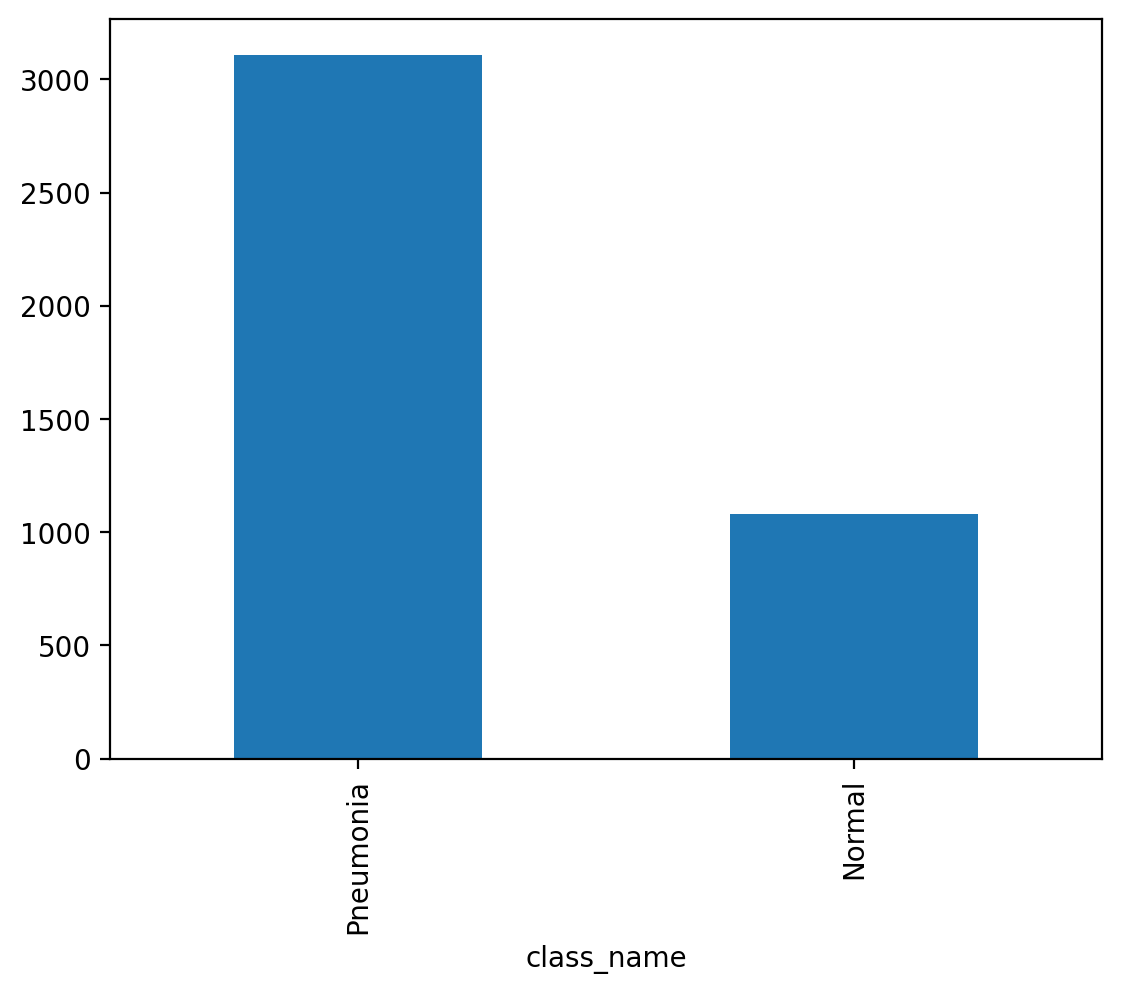

In [33]:
class_dict = {0:'Normal', 1:'Pneumonia'}
train_data['class_name'] = train_data.label.map(class_dict)
train_data['class_name'].value_counts().plot(kind='bar')

In [34]:
for filepath in train_data.image_path:
    image = cv2.imread(filepath)
    image_size = image.shape
    break
image_size

(1252, 1666, 3)

In [35]:
BATCH_SIZE = 32
IMG_SHAPE  = 224

train_image_gen = ImageDataGenerator(rescale=1./255,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     brightness_range=[0.2,1.0],
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

train_gen = train_image_gen.flow_from_dataframe(train_data,
                                              x_col='image_path',
                                              y_col='class_name',
                                              class_mode='binary',
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              target_size=(IMG_SHAPE,IMG_SHAPE))

Found 4192 validated image filenames belonging to 2 classes.


In [36]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

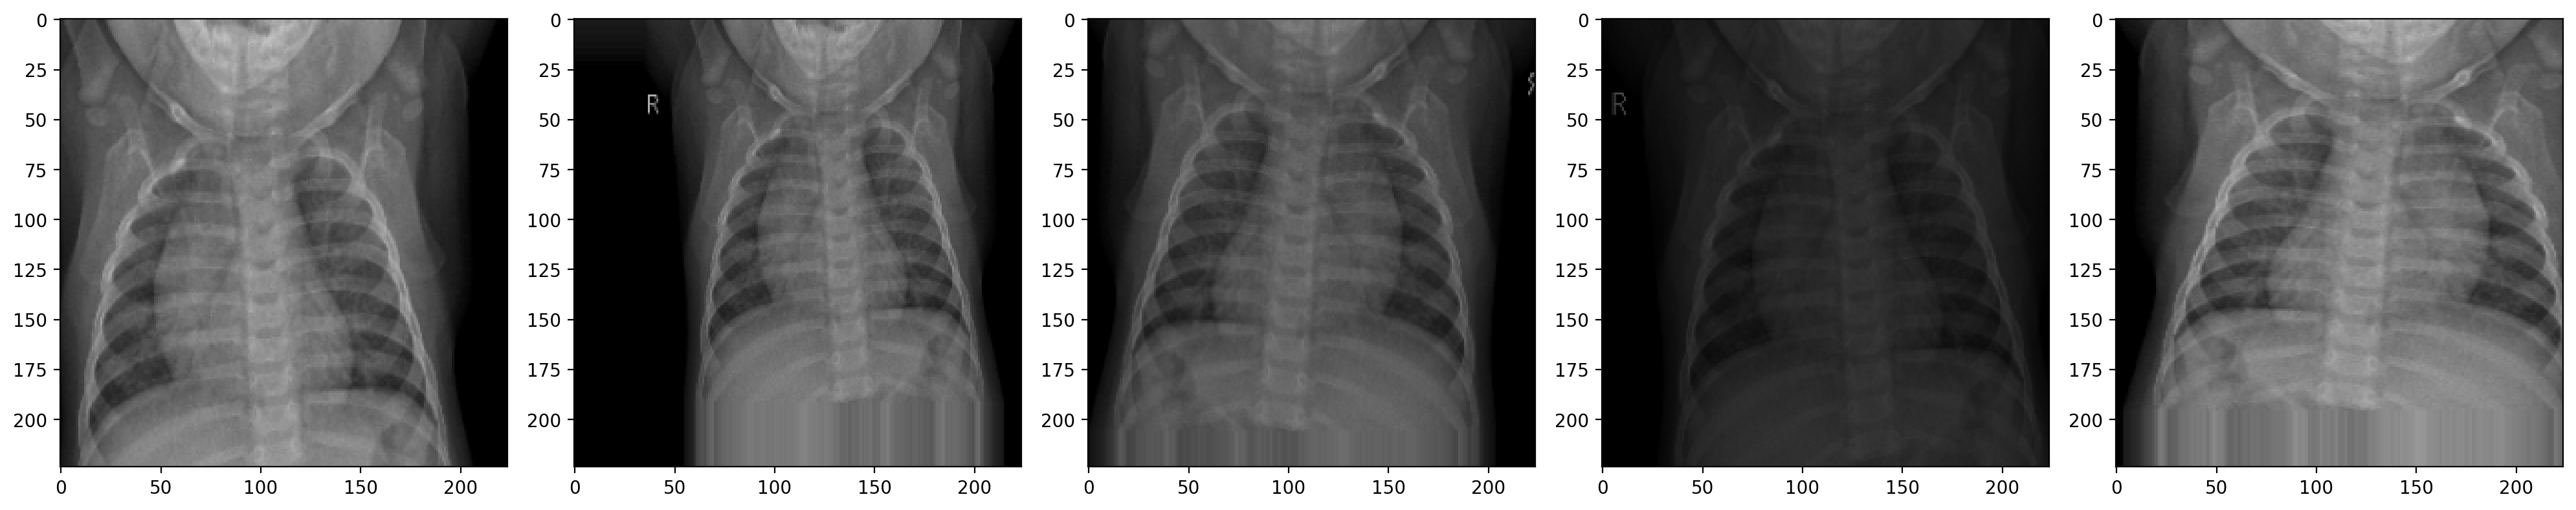

In [37]:
augmented_images = [train_gen[0][0][2] for i in range(5)]
plotImages(augmented_images)

In [38]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

train_lb = to_categorical(train_data.label, dtype = int)
val_lb = to_categorical(val_data.label, dtype=int)

train_data = train_data.reset_index().drop(labels='index', axis=1)
y_train = pd.DataFrame(train_lb).add_prefix('label_')

val_data = val_data.reset_index().drop(labels='index', axis=1)
y_val = pd.DataFrame(val_lb).add_prefix('label_')

train_data = pd.concat([train_data, y_train], axis=1)
val_data = pd.concat([val_data, y_val], axis=1)

print("Training set has {} samples".format(train_data.shape[0]))
print("Validation set has {} samples".format(val_data.shape[0]))

Training set has 4192 samples
Validation set has 1040 samples


In [39]:
BATCH_SIZE = 32
IMG_SHAPE  = 224
EPOCHS = 1

def gen():
    train_image_gen = ImageDataGenerator(rescale=1./255,
                                         width_shift_range=0.1,
                                         height_shift_range=0.1,
                                         brightness_range=[0.2,1.0],
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         fill_mode='nearest')

    train_gen = train_image_gen.flow_from_dataframe(train_data,
                                              x_col='image_path',
                                              y_col=[f'label_{x}' for x in np.arange(2)],
                                              class_mode='raw',
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              target_size=(IMG_SHAPE,IMG_SHAPE))


    val_image_gen = ImageDataGenerator(rescale=1./255)

    val_gen = val_image_gen.flow_from_dataframe(val_data,
                                              x_col='image_path',
                                              y_col= [f'label_{x}' for x in np.arange(2)],
                                              class_mode='raw',
                                              batch_size=BATCH_SIZE,
                                              target_size=(IMG_SHAPE,IMG_SHAPE))
    return train_gen, val_gen

In [40]:
def plot(history):

    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    epochs_range=range(len(training_accuracy))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
    plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, training_loss, label='Training Loss')
    plt.plot(epochs_range, validation_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [41]:
from PIL import Image
def predict(image_path, model):
    im = cv2.imread(image_path)
    test_image = np.asarray(im)
    processed_test_image = process_image(test_image)
    processed_test_image = np.expand_dims(processed_test_image, axis = 0)
    
    ps = model.predict(processed_test_image)
    return ps
    
def process_image(image):
    image = tf.cast(image , tf.float32)
    image = tf.image.resize(image , (224 , 224))
    image = image/255
    image = image.numpy()
    return image

In [42]:
#MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

base = MobileNetV2(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
tf.keras.backend.clear_session()
    
for layer in base.layers:
    layer.trainable =  False

mobilenet_model = Sequential()
mobilenet_model.add(base)
mobilenet_model.add(GlobalAveragePooling2D())
mobilenet_model.add(BatchNormalization())
mobilenet_model.add(Dense(256, activation='relu'))
mobilenet_model.add(Dropout(0.5))
mobilenet_model.add(BatchNormalization())
mobilenet_model.add(Dense(128, activation='relu'))
mobilenet_model.add(Dropout(0.5))
mobilenet_model.add(Dense(2, activation='softmax'))

mobilenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

In [43]:
train_gen, val_gen = gen()

optm = Adam(lr=0.0001)
mobilenet_model.compile(loss='binary_crossentropy', optimizer=optm, 
                  metrics=['accuracy'])

EarlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=.0001,
                              patience=3,
                              verbose=1,
                              mode='auto',
                              restore_best_weights=True)

model_save = ModelCheckpoint('./mobilenetV2.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)


mob_history = mobilenet_model.fit(train_gen,
                              steps_per_epoch = train_gen.samples // BATCH_SIZE,
                              epochs = EPOCHS,
                              validation_data = val_gen,
                              callbacks=[EarlyStopping, model_save])

Found 4192 validated image filenames.
Found 1040 validated image filenames.


131/131 [==============================] - ETA: 0s - loss: 0.3321 - accuracy: 0.8686
Epoch 1: val_loss improved from inf to 0.17697, saving model to .\mobilenetV2.h5
131/131 [==============================] - 472s 4s/step - loss: 0.3321 - accuracy: 0.8686 - val_loss: 0.1770 - val_accuracy: 0.9375


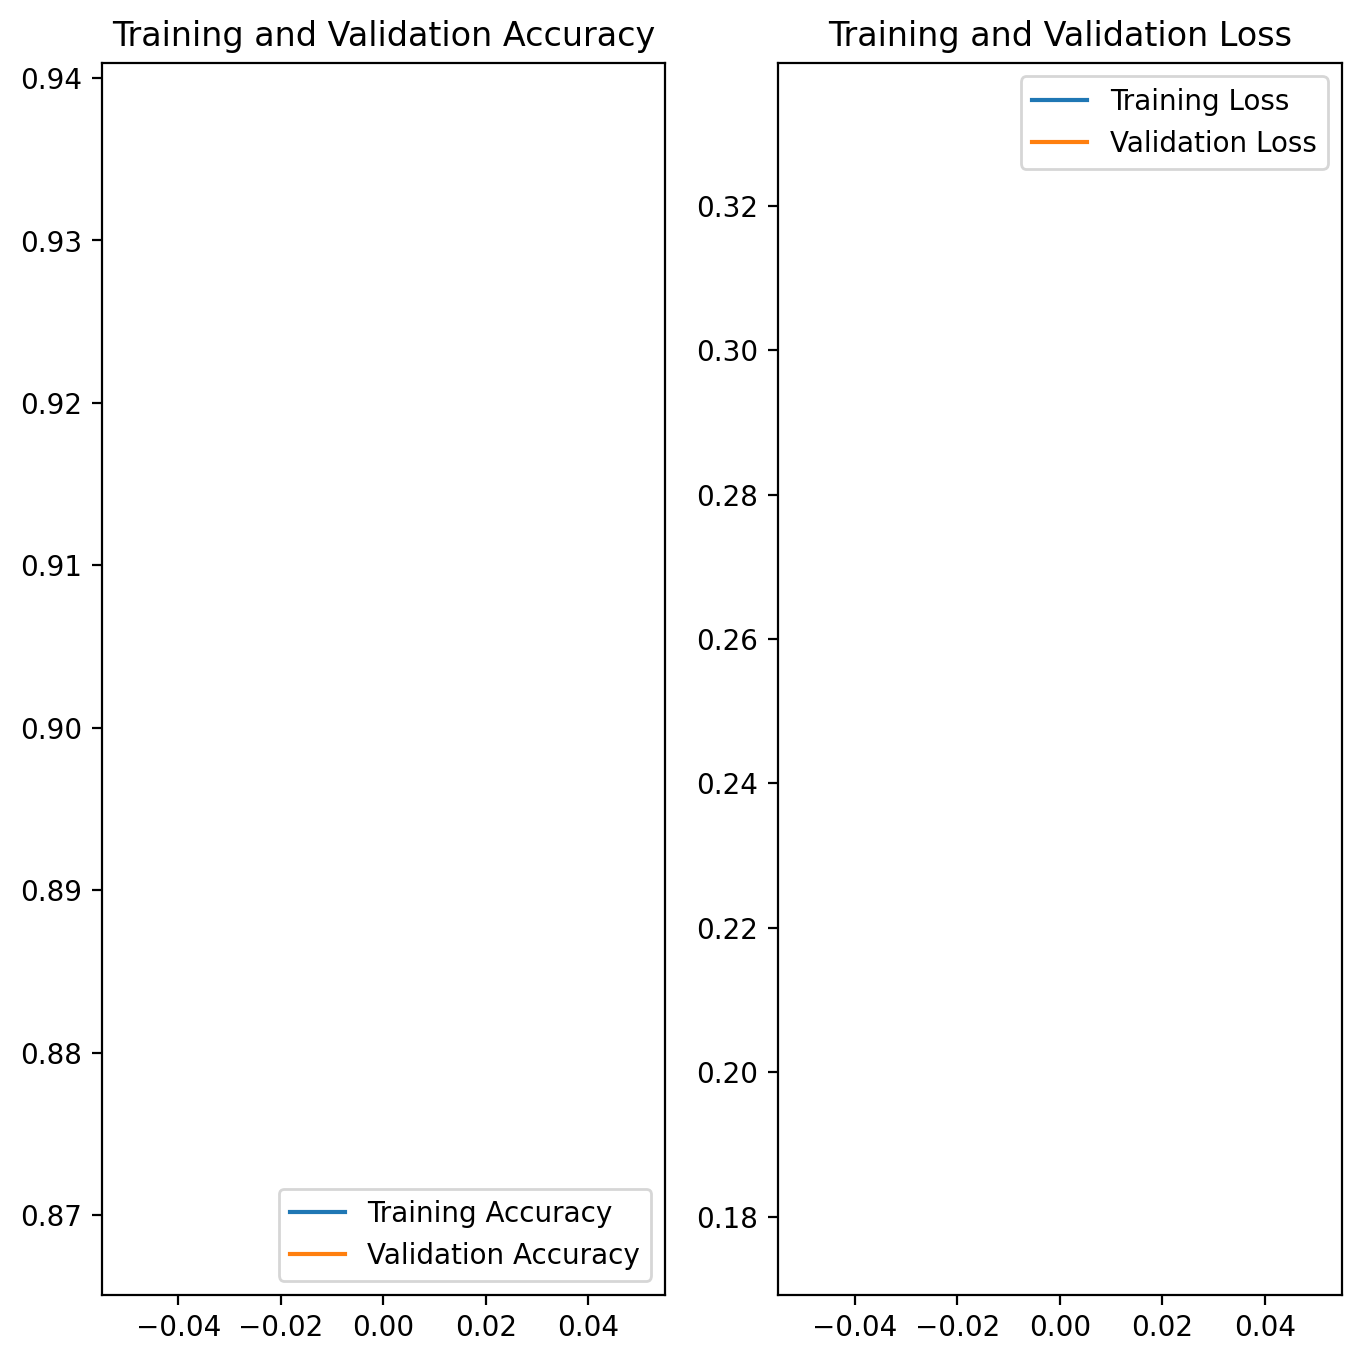

In [44]:
mobilenet_model.save('./mobilenetV2.h5')
plot(mob_history)


In [45]:
mob_pred =[]
for image in test_data.image_path:
    mob_pred.append(predict(image , mobilenet_model))
    
final_mob_pred  = np.argmax(mob_pred , axis=-1)
actual_label = test_data['label']

print(classification_report(actual_label, final_mob_pred))
matrix=confusion_matrix(actual_label, final_mob_pred)
sns.heatmap(matrix,square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

1/1 [==============================] - 0s 100ms/step


NameError: name 'classification_report' is not defined

In [ ]:
print(mob_history.history['val_accuracy'][-4])
print(mob_history.history['val_loss'][-4])